In [18]:
import os
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks, Input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter

In [ ]:
def load_npz_data(data_dir, prefix):
    Xfile = np.load(f"{data_dir}/X_{prefix}_beats.npz")
    Zfile = np.load(f"{data_dir}/Z_{prefix}_beats.npz")
    # Ambil array pertama (apapun key-nya)
    X = Xfile[Xfile.files[0]]
    Z = Zfile[Zfile.files[0]]
    return X, Z

def minmax_normalize_beats(X_beats):
    # X_beats shape: (n_beats, 55, 12)
    min_val = X_beats.min(axis=1, keepdims=True)  # shape (n_beats, 1, 12)
    max_val = X_beats.max(axis=1, keepdims=True)
    X_norm = (X_beats - min_val) / (max_val - min_val + 1e-8)
    return X_norm

def denoise_beats(X_beats, window_length=7, polyorder=2):
    # X_beats shape: (n_beats, 55, 12)
    denoised = savgol_filter(X_beats, window_length=window_length, polyorder=polyorder, axis=1)
    return denoised


In [16]:
data_dir = 'data_ready'
X_train, Z_train = load_npz_data(data_dir, 'train')
X_val, Z_val = load_npz_data(data_dir, 'valid')
X_test, Z_test = load_npz_data(data_dir, 'test')


# Normalize each beat
X_train = minmax_normalize_beats(X_train)
X_val = minmax_normalize_beats(X_val)
X_test = minmax_normalize_beats(X_test)

y_train = Z_train
y_val = Z_val
y_test = Z_test
print("Train beats :", X_train.shape, y_train.shape)
print("Valid beats :", X_val.shape, y_val.shape)
print("Test beats  :", X_test.shape, y_test.shape)

Train beats : (170370, 55, 12) (170370, 5)
Valid beats : (48370, 55, 12) (48370, 5)
Test beats  : (24257, 55, 12) (24257, 5)


In [20]:
# Denoising
X_train_denoised = denoise_beats(X_train)
X_val_denoised = denoise_beats(X_val)
X_test_denoised = denoise_beats(X_test)

# Normalisasi
X_train_norm = minmax_normalize_beats(X_train_denoised)
X_val_norm = minmax_normalize_beats(X_val_denoised)
X_test_norm = minmax_normalize_beats(X_test_denoised)

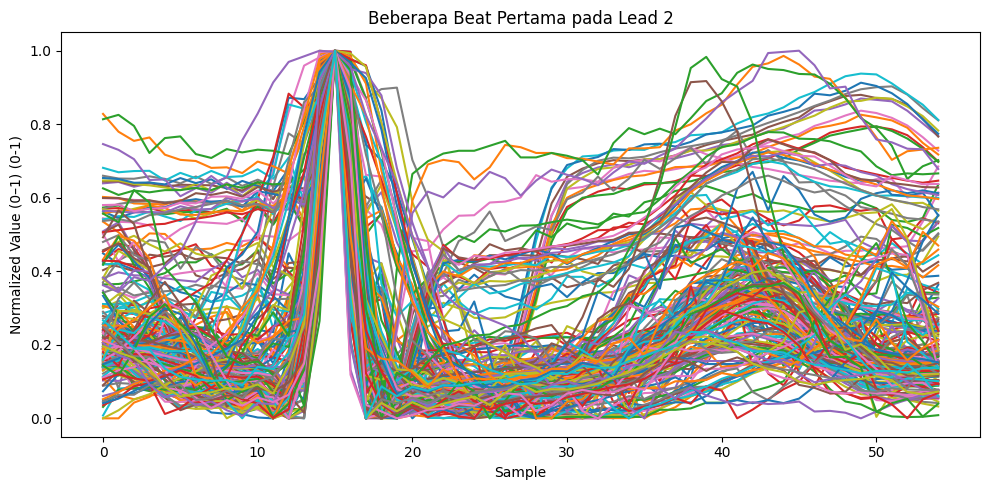

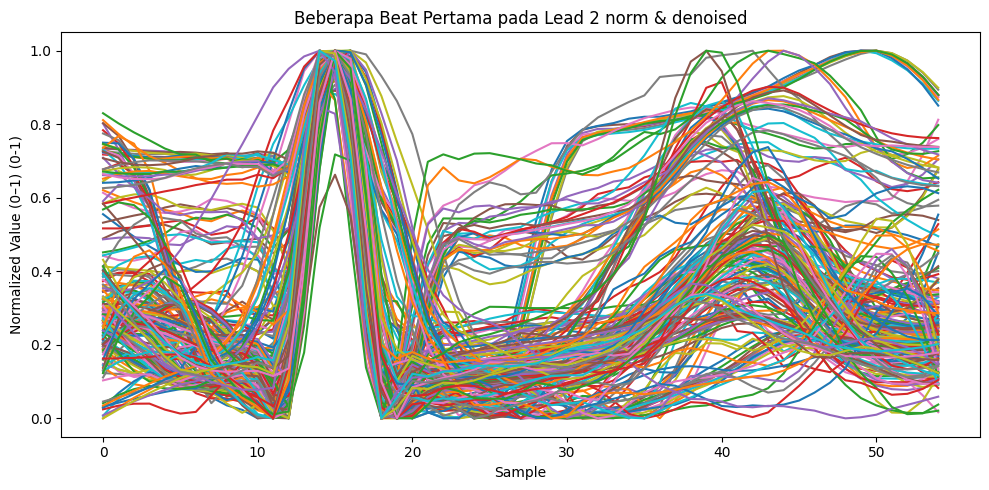

In [26]:
import matplotlib.pyplot as plt

lead_index = 1  # Change dengan indeks lead yang ingin dilihat (for example: 0 for lead 1, 1 for lead 2, dst)
n_show = 200      # Berapa beat yang ingin diDisplay


plt.figure(figsize=(10, 5))
for i in range(n_show):
    plt.plot(X_train[i][:, lead_index], label=f'Beat {i+1} ')

plt.title(f'Beberapa Beat Pertama pada Lead {lead_index+1}')
plt.xlabel("Sample")
plt.ylabel("Normalized Value (0–1) (0-1)")
# plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for i in range(n_show):
    plt.plot(X_train_norm[i][:, lead_index], label=f'Beat {i+1} ')

plt.title(f'Beberapa Beat Pertama pada Lead {lead_index+1} norm & denoised')
plt.xlabel("Sample")
plt.ylabel("Normalized Value (0–1) (0-1)")
# plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()




In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np

# 1. Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * epsilon

# 2. Encoder
def create_encoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)
    x = layers.Conv1D(64, 5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(2)(x)  # 55 → 27
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)  # 27 → 13
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    mu = layers.Dense(latent_dim, name='mu')(x)
    log_var = layers.Dense(latent_dim, name='log_var')(x)
    z = Sampling()([mu, log_var])
    return Model(inputs, [mu, log_var, z], name="Encoder")

# 3. Decoder
def create_decoder(output_shape, latent_dim):
    target_timesteps, num_leads = output_shape
    latent_inputs = Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(latent_inputs)
    x = layers.Dense((target_timesteps // 4) * 128, activation='relu')(x)
    x = layers.Reshape((target_timesteps // 4, 128))(x)  # 13
    x = layers.UpSampling1D(size=2)(x)   # 13 → 26
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling1D(size=2)(x)   # 26 → 52
    x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv1D(num_leads, 3, padding='same', activation='sigmoid')(x)
    x = layers.ZeroPadding1D(padding=(0, target_timesteps - 52))(x)
    outputs = x
    return Model(latent_inputs, outputs, name="Decoder")

# 4. Classifier head (z → Dense128 → Dropout → DenseSoftmax)
def create_classifier(latent_dim, num_classes):
    latent_input = Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(latent_input)
    x = layers.Dropout(0.5)(x)
    class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(x)
    return Model(latent_input, class_output, name="Classifier")

# 5. VAE-Classifier Model (custom train_step & test_step)
class VAEClassifier(Model):
    def __init__(self, encoder, decoder, classifier, alpha=1.0, **kwargs):
        super(VAEClassifier, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier
        self.alpha = alpha  # loss weight for classification

    def compile(self, optimizer):
        super(VAEClassifier, self).compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.class_loss_tracker = tf.keras.metrics.Mean(name="class_loss")
        self.class_acc = tf.keras.metrics.CategoricalAccuracy(name="acc")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker,
            self.class_loss_tracker,
            self.class_acc
        ]

    def train_step(self, data):
        (x, y) = data  # x: input signal, y: one-hot label
        with tf.GradientTape() as tape:
            mu, log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            y_pred = self.classifier(z)
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction), axis=[1,2]))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1))
            class_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y, y_pred))
            total_loss = recon_loss + kl_loss + self.alpha * class_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.class_loss_tracker.update_state(class_loss)
        self.class_acc.update_state(y, y_pred)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "class_loss": self.class_loss_tracker.result(),
            "acc": self.class_acc.result()
        }

    def test_step(self, data):
        (x, y) = data
        mu, log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        y_pred = self.classifier(z)
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction), axis=[1,2]))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1))
        class_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y, y_pred))
        total_loss = recon_loss + kl_loss + self.alpha * class_loss
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.class_loss_tracker.update_state(class_loss)
        self.class_acc.update_state(y, y_pred)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "class_loss": self.class_loss_tracker.result(),
            "acc": self.class_acc.result()
        }

    def call(self, inputs):
        mu, log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        y_pred = self.classifier(z)
        return reconstruction, y_pred

In [29]:
# 6. Build Model, Compile, and Train
input_shape = (55, 12)
latent_dim = 32
num_classes = 5   # Jumlah kelas target

encoder = create_encoder(input_shape, latent_dim)
decoder = create_decoder(input_shape, latent_dim)
classifier = create_classifier(latent_dim, num_classes)
vaeclf = VAEClassifier(encoder, decoder, classifier, alpha=1.0)
vaeclf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

vaeclf.fit(
    X_train_norm,             # <-- input beats (170370, 55, 12)
    y_train,             # <-- one-hot labels (170370, 5)
    epochs=5,
    batch_size=50,
    validation_data=(X_val, y_val)
)

_, y_pred_prob = vaeclf.predict(X_test, batch_size=50)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
from sklearn.metrics import accuracy_score, classification_report
print("Test Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Epoch 1/5
3408/3408 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - acc: 0.4122 - class_loss: 1.9217 - kl_loss: 6.0931 - loss: 41.1569 - recon_loss: 33.1421 - val_acc: 0.5191 - val_class_loss: 1.7712 - val_kl_loss: 371.2411 - val_loss: 397.1057 - val_recon_loss: 24.0930
Epoch 2/5
3408/3408 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - acc: 0.4913 - class_loss: 2.0236 - kl_loss: 1937.0184 - loss: 1961.5907 - recon_loss: 22.5487 - val_acc: 0.5486 - val_class_loss: 1.9912 - val_kl_loss: 12442.0215 - val_loss: 12467.7686 - val_recon_loss: 23.7563
Epoch 3/5
3408/3408 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - acc: 0.4672 - class_loss: 3.6030 - kl_loss: 18321.2812 - loss: 18346.9277 - recon_loss: 22.0416 - val_acc: 0.5661 - val_class_loss: 3.5839 - val_kl_loss: 50814.7930 - val_loss: 50842.2148 - val_recon_loss: 23.8701
Epoch 4/5
3408/3408 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - acc: 0.4223 - class_loss: 9.1765 - kl_loss: 59821.1016 - loss: 59851.6680 - recon_loss: 21.4023 - val_acc: 0.5172 - val_class_loss: 33.4479 - val_k

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
